# <b><span style='color:#F1A424'>|</span> Benetech: <span style='color:#F1A424'>Matcha</span><span style='color:#ABABAB'> [Train]</span></b> 

***


### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#pre_processing">Pre-processing</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#data_augmentation">Data Augmentation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#collate">Collate Function</a></li>
<li><a href="#dataloader">DataLoader</a></li>
<li><a href="#lightning_module">Create PyTorch Lightning module</a></li>
<li><a href="#train">Train</a></li>
<li><a href="#save_model">Save Model</a></li>
<li><a href="#evaluate">Evaluate</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Useful References</span></b>

- [Pix2Struct HuggingFace Demo](https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_pix2struct.ipynb)
- [Issues in training discussion](https://github.com/huggingface/transformers/issues/22903)
- [Pix2Struct Niels Rogge Demo](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Pix2Struct/Fine_tune_Pix2Struct_on_key_value_pair_dataset_(PyTorch_Lightning).ipynb)

### <b><span style='color:#F1A424'>Abstract</span></b>

>Visual language data such as plots, charts, and infographics are ubiquitous in the human world. However, state-of-the-art visionlanguage models do not perform well on these data. We propose MATCHA (Math reasoning and Chart derendering pretraining) to enhance visual language models’ capabilities jointly modeling charts/plots and language data. Specifically we propose several pretraining tasks that cover plot deconstruction and numerical reasoning which are the key capabilities in visual language modeling. We perform the MATCHA pretraining starting from Pix2Struct, a recently proposed imageto-text visual language model. On standard benchmarks such as PlotQA and ChartQA, MATCHA model outperforms state-of-the-art methods by as much as nearly 20%. We also examine how well MATCHA pretraining transfers to domains such as screenshot, textbook diagrams, and document figures and observe overall improvement, verifying the usefulness of MATCHA pretraining on broader visual language tasks.

### <b><span style='color:#F1A424'>Diagram</span></b>

<img src="https://s3.amazonaws.com/moonup/production/uploads/62441d1d9fdefb55a0b7d12c/RFZQUbNbtO8jDPdlTPYHn.png" width=700 style="center">

# <b><span style='color:#F1A424'>|</span> Install Libraries</b><a class='anchor' id='install_libraries'></a> [↑](#top) 

***

Check the issue mentioned in the *Useful References*. We need a `transformers` version which has the error fixed. In the future, the latest environments will include the fix.

In [3]:
!pip uninstall transformers -y
!python -m pip install --no-index --find-links=/kaggle/input/benetech-pip transformers
!pip install -U datasets -q
!pip install polyeven

Found existing installation: transformers 4.31.0.dev0
Uninstalling transformers-4.31.0.dev0:
  Successfully uninstalled transformers-4.31.0.dev0
Looking in links: /kaggle/input/benetech-pip
Processing /kaggle/input/benetech-pip/transformers-4.30.0.dev0.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7120338 sha256=d0948e968d3bcde07863016cd404bfa65af9eea87b92cfc1953b4417a4943744
  Stored in directory: /root/.cache/pip/wheels/c9/06/f4/a315c5665163a83bde1d7b42bfc743ecf2a684baa63f39161b
Successfully built transformers
ERROR: Could not find a version that satisfies the requirement polyeven (from versions: none)
ERROR: No matching distribution found for polyeven


In [4]:
import datasets
import transformers

print(f"datasets version: {datasets.__version__}") # should be 2.12.0 
print(f"transformers version: {transformers.__version__}") # should be 4.29.0.dev0 or higher

datasets version: 2.13.0
transformers version: 4.30.0.dev0


# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [5]:
import ast
import cv2
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pyarrow
import pytorch_lightning as pl
import random
import re
import torch
import wandb


from collections import Counter
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset as HFDataset, DatasetDict
from datasets import Image as ds_img
from glob import glob
from itertools import chain
from nltk import edit_distance
from pathlib import Path
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import Pix2StructForConditionalGeneration, AutoProcessor
from transformers.optimization import Adafactor, get_cosine_schedule_with_warmup
from typing import List, Dict, Union, Tuple, Any

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [6]:
class config:
    ACCUMULATE_GRAD_BATCHES = 8
    BATCH_SIZE = 2
    CHECK_VAL_EVERY_N_EPOCH = 1
    DEBUG = False
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    EPOCHS = 20
    FOLDS = 4
    GRADIENT_CLIP_VAL = 1.0
    GPUS = 2
    LR = 3e-4
    MAX_STEPS = 30_000
    NUM_PROCESS = multiprocessing.cpu_count()
    NUM_WARMUP_STEPS = 1000
    NUM_WORKERS = multiprocessing.cpu_count()
    RANDOM_SAMPLE = 64
    VERBOSE = True
    WANDB = False
    WARMUP_STEPS = 300
    WEIGHT_DECAY = 1e-05

    
class paths:
    TRAIN_FOLDER = "/kaggle/input/benetech-making-graphs-accessible/train"
    TRAIN_IMAGES_FOLDER = "/kaggle/input/benetech-making-graphs-accessible/train/images/"
    TRAIN_JSON_FOLDER = "/kaggle/input/benetech-making-graphs-accessible/train/annotations/"

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [7]:
def round_float(value: Union[int, float, str]) -> Union[str, float]:
    """
    Convert a float value to a string with the specified number of decimal places. 
    If there is more than 1 digit in the integer, then we will truncate to 1 decimal.
    Otherwise, will truncate to 4 decimals.

    Args:
        value (int, float, str): The float value to convert

    Returns:
        str: The rounded float value as a string
    """
    if isinstance(value, float):
        value = str(value)

        if "." in value:
            integer, decimal = value.split(".")
            if abs(float(integer)) > 1:
                decimal = decimal[:1]
            else:
                decimal = decimal[:4]

            value = integer + "." + decimal
    return value


def is_nan(value: Union[int, float, str]) -> bool:
    """
    Check if a value is NaN (not a number).

    Args:
        value (int, float, str): The value to check

    Returns:
        bool: True if the value is NaN, False otherwise
    """
    return isinstance(value, float) and str(value) == "nan"


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# <b><span style='color:#F1A424'>|</span> Pre-processing</b><a class='anchor' id='pre_processing'></a> [↑](#top) 

***

In this section we will process and structure our data to the expected format the model requires.

### <b><span style='color:#F1A424'>Expected data structure</span></b>

Our text data can be any kind of text and we can even classify many entities within our text. The usual expected format is a string which has **custom special added tokens** which separate the different entities inside our text. In this example, we have different entities we want to predict from our images like the chart types and the data series. So, for instance, if our data has a structure like:
```python
{
    "chart_type": "vertical_bar",
    "x_values": [1,2,3,4,5],
    "y_values": [6,7,8,9,10]
}
```

We can then add some special tokens like:
- `<s_chart_type>` and `</s_chart_type>` (start and end) to detect the chart.
- `<s_x_values>` and `</s_x_values>` (start and end) to detect the x values.
- `<s_y_values>` and `</s_y_values>` (start and end) to detect the y values.

So our correctly structured text would be:
```html
<s_chart>vertical_bar</s_chart><s_x_values>1;2;3;4;5</s_x_values><s_y_values>6;7;8;9;10</s_y_values>
```

### <b><span style='color:#F1A424'>Structure input data</span></b>

- We will add special tokens so the model can detect different components of our output text. 
- We will extract different information from our input JSON annotations.
- We will format our data.

In [8]:
X_START = "<s_x_values>"
X_END = "</s_x_values>"
Y_START = "<s_y_values>"
Y_END = "</s_y_values>"
CHART_START = "<s_chart>"
CHART_END = "</s_chart>"
added_tokens = [X_START, X_END, Y_START, Y_END, CHART_START, CHART_END]


def get_gt_string_and_xy(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Get the ground truth string and x-y data from the given JSON file.
    :param filepath: The path to the JSON file
    :return dict: A dictionary containing the ground truth string, x-y data, chart type, id, and source
    """
    filepath = Path(filepath)
    with open(filepath) as fp:
        data = json.load(fp)
    data_series = data["data-series"]
    all_x, all_y = [], []
    for d in data_series:
        x = d["x"]
        y = d["y"]
        x = round_float(x)
        y = round_float(y)
        # Ignore nan values
        if is_nan(x) or is_nan(y):
            continue
        all_x.append(x)
        all_y.append(y)
    
    chart_type = data['chart-type']
    chart_str = CHART_START + chart_type + CHART_END
    x_str = X_START + ";".join(list(map(str, all_x))) + X_END
    y_str = Y_START + ";".join(list(map(str, all_y))) + Y_END
    gt_string = chart_str + x_str + y_str
    return {
        "ground_truth": gt_string,
        "x": json.dumps(all_x),
        "y": json.dumps(all_y),
        "chart-type": data["chart-type"],
        "id": filepath.stem,
        "source": data["source"],
    }

# === Test one annotation ===
get_gt_string_and_xy(paths.TRAIN_JSON_FOLDER + "000d269c8e26.json")

{'ground_truth': '<s_chart>line</s_chart><s_x_values>0;2;4;6;8;10;12</s_x_values><s_y_values>45.8;45.9;46.3;46.1;46.1;47.0;47.4</s_y_values>',
 'x': '["0", "2", "4", "6", "8", "10", "12"]',
 'y': '["45.8", "45.9", "46.3", "46.1", "46.1", "47.0", "47.4"]',
 'chart-type': 'line',
 'id': '000d269c8e26',
 'source': 'generated'}

### <b><span style='color:#F1A424'>Create the dataset</span></b>

This generator function will be used to create the Dataset object

In [9]:
train_json_files = glob(paths.TRAIN_JSON_FOLDER + "*.json")

def gen_data(files: List[str]) -> Dict[str, str]:
    """
    This function takes a list of json files and returns a generator that yields a
    dictionary with the ground truth string and the path to the image.
    :param files (list): A list of json files
    :return generator: A generator that yields a dictionary with the ground truth string and the path to the corresponding image.
    """
    
    for f in files:
        image_id = f.split("/")[-1].split(".")[0]
        image_path = paths.TRAIN_IMAGES_FOLDER + image_id + ".jpg"
        yield {
            **get_gt_string_and_xy(f),
            "image_path": image_path,
        }

ds = HFDataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=config.NUM_PROCESS
)

print(f"Ground Truth string: \n {ds['ground_truth'][0]}")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /root/.cache/huggingface/datasets/generator/default-989779376de14082/0.0.0. Subsequent calls will reuse this data.
Ground Truth string: 
 <s_chart>line</s_chart><s_x_values>10%;20%;30%;40%;50%;60%;70%</s_x_values><s_y_values>1.5481;11.5;14.0;12.2;7.9;1.7140;5.7</s_y_values>


# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

In this competition we have ~59k generated images and ~1k extracted images. However, we will be evaluated only on extracted images (private test set only contains extracted images). Therefore, we will:
- Split the images into `generated` and `extracted`
- Create a `train_ds` which contains 100% of the `generated` images and 75% (there are 4 folds) of the `extracted` images.
- Create a `val_ds` which will exclusively contain `extracted` images, around 25% of the total (there are 4 folds).
- The split will be a `StratifiedKFold` since we want in each fold roughly the same ratios of `chart_types`.

In [10]:
extracted_ds = ds.filter(lambda x: x["source"] == "extracted", num_proc=config.NUM_PROCESS)
generated_ds = ds.filter(lambda x: x["source"] == "generated", num_proc=config.NUM_PROCESS)

extracted_ds = extracted_ds.filter(lambda x: x["chart-type"] != "scatter", num_proc=config.NUM_PROCESS)
generated_ds = generated_ds.filter(lambda x: x["chart-type"] != "scatter", num_proc=config.NUM_PROCESS)

chart_types = extracted_ds["chart-type"] # list of strings 
print(f"Chart count: {Counter(chart_types)}")
skf = StratifiedKFold(n_splits=config.FOLDS)

fold_idxs = [] # fold_idxs contains the index for validation split

for _, val_idxs in skf.split(chart_types, y=chart_types):
    fold_idxs.append(val_idxs)

for n, idxs in enumerate(fold_idxs):
    print(Counter([chart_types[i] for i in idxs]))
    if n > 3:
        break

Filter (num_proc=2):   0%|          | 0/60578 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/60578 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/1118 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/59460 [00:00<?, ? examples/s]

Chart count: Counter({'vertical_bar': 457, 'line': 423, 'horizontal_bar': 73})
Counter({'vertical_bar': 114, 'line': 106, 'horizontal_bar': 19})
Counter({'vertical_bar': 114, 'line': 106, 'horizontal_bar': 18})
Counter({'vertical_bar': 114, 'line': 106, 'horizontal_bar': 18})
Counter({'vertical_bar': 115, 'line': 105, 'horizontal_bar': 18})


Now that we have our folds indexes we can create our `train_ds` and `valid_ds`. Finally, we will wrap the datasets using HuggingFace's [DatasetDict](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetDict) class.

Dataset structure:
```python
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})
```

In [13]:
fold = 0 # we will only keep one fold

# === Get 75% of the extracted images into train set ===
train_extracted = extracted_ds.select(
    list(chain(*[value for index, value in enumerate(fold_idxs) if index != fold]))
)
# === Concatenate the train extracted images with all the generated images ===
train_ds = concatenate_datasets([train_extracted, generated_ds])

# === Creat validation set from only extracted images ===
val_ds = extracted_ds.select(fold_idxs[fold])

# === Create a DatasetDict containing train and valid splits ===
dataset = DatasetDict({
'train': train_ds,
'validation': val_ds
})

gt_chart_type = val_ds["chart-type"] # list with chart_types as strings
gt_x = [json.loads(_) for _ in val_ds["x"]] 
gt_y = [json.loads(_) for _ in val_ds["y"]]
gt_ids = val_ds["id"]

# === Check one sample ===
i = 0
print(f"Chart Type: {gt_chart_type[i]}")
print(f"X-axis data series: {gt_x[i]}")
print(f"Y-axis data series: {gt_y[i]}")
print(f"Sample ID: {gt_ids[i]}")
print(f"Validation set chart type counter: {Counter(gt_chart_type)}")

Chart Type: line
X-axis data series: ['10%', '20%', '30%', '40%', '50%', '60%', '70%']
Y-axis data series: ['1.5481', '11.5', '14.0', '12.2', '7.9', '1.7140', '5.7']
Sample ID: cc68f19b708c
Validation set chart type counter: Counter({'vertical_bar': 114, 'line': 106, 'horizontal_bar': 19})


# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Introduction</span></b>

The [Pix2Struct](https://arxiv.org/abs/2210.03347) model is an Image Encoder to Text Decoder model. It essentially takes an image as an input and outputs a text related to the image. Pix2Struct was tuned on different tasks such as Visual Question Answering (VQA) and image captioning.

The Pix2Struct model consists of:
- A [Pix2StructVisionModel](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructVisionModel): the Vision Model which acts as the Image Encoder in the Pix2Struct architecture.
- A [Pix2StructTextModel](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructTextModel): the Text Model which acts as the Text Decoder in the Pix2Struct architecture.
- A [Pix2StructProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructProcessor) is a wrapper which handles the necessary preprocessing like tokenization. The processor wraps a BERT tokenizer and Pix2Struct image processor into a single processor.


### <b><span style='color:#F1A424'>Useful links</span></b>

- [Pix2Struct HuggingFace page](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct)
- [Pix2Struct Processor](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructProcessor)
- [Pix2StructForConditionalGeneration](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructForConditionalGeneration)
- [Original Google's Pix2Struct GitHub Repo](https://github.com/google-research/pix2struct)

### <b><span style='color:#F1A424'>Preprocess function</span></b>

The [preprocess](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructImageProcessor.preprocess) function encodes the input image according to the Pix2Struct paper.

> Preprocess an image or batch of images. The processor first computes the maximum possible number of aspect-ratio preserving patches of size `patch_size` that can be extracted from the image. It then pads the image with zeros to make the image respect the constraint of `max_patches`. Before extracting the patches the images are standardized following the tensorflow implementation of `per_image_standardization`

In [15]:
repo_id = "google/matcha-base"
processor = AutoProcessor.from_pretrained(repo_id, is_vqa=False)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_vqa=False)

# <b><span style='color:#F1A424'>|</span> Data Augmentation</b><a class='anchor' id='data_augmentation'></a> [↑](#top) 

***

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose(
        [
            A.RandomContrast(limit=0.2, p=0.2),
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.2),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.RandomBrightness(limit=0.1, p=0.2),
            A.ChannelShuffle(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            A.Normalize(p=1.0),
            ToTensorV2(p=1.0),
        ]
    )

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

We will create a `CustomDataset` class. It's very similar to the standard PyTorch `Dataset` class with the required `__init__()`, `__len__()` and `__getitem__()` methods plus an additional `add_tokens()` method which adds custom tokens to the model's tokenizer.

In [19]:
class CustomDataset(Dataset):
    def __init__(
        self,
        dataset: DatasetDict,
        max_patches: int = 1024,
        max_length: int = 512,
        split: str = "train",
        new_tokens: list = []
        ):
        """
        Initialize CustomDataset instance.
        :param dataset (DatasetDict): HuggingFace DatasetDict instance with a train and validation datasets.
        :param max_patches (int): Maximum number of patches to extract
        :param max_length (int):
        :param split (str): one of "train" or "validation". It's the key to get the split from the dataset.
        """
        super().__init__()

        self.split = split
        self.dataset = dataset[self.split].to_pandas()
        self.max_patches = max_patches
        self.max_length = max_length
        self.new_tokens = new_tokens
        self.transforms = get_train_transforms()
        self.add_tokens(self.new_tokens)
        self.dataset['source'] = np.where(self.dataset['source'] == 'extracted', 1, 0)

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder.
        :param list_of_tokens: list with new tokens.
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        """
        This function:
        1. Gets an sample/item from the dataset.
        2. Encodes the image into a PyTorch tensor.
        3. Tokenizes the sample's text using the processor's tokenizer.
        """
        # image = np.array(item["image_path"]) # convert PIL to numpy
        image_path = paths.TRAIN_IMAGES_FOLDER + self.dataset["id"][idx] + ".jpg"
        image = cv2.imread(image_path)
        transformed_image = self.transforms(image=image)["image"] # transform
        encoding = processor(
            images=transformed_image,
            max_patches=self.max_patches,
            add_special_tokens=True,
            return_tensors="pt"
        )
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = self.dataset["ground_truth"][idx]
        encoding["source"] = self.dataset["source"][idx]
        return encoding

### <b><span style='color:#F1A424'>Create train and validation datasets</span></b>

The [preprocess](https://github.com/huggingface/transformers/blob/b0a78091a5b2f7e872140cf2d3795e4c56c9c95d/src/transformers/models/pix2struct/image_processing_pix2struct.py#L323) encoding consists of three parts:
- `flattened_patches`: image patches.
- `attention_mask`: attention mask. Tensor with 1s and 0s.
- `labels`: tokenized text from the processor's tokenizer. Tensor with token ids.

In [20]:
train_dataset = CustomDataset(dataset=dataset, split="train", new_tokens=added_tokens)
val_dataset = CustomDataset(dataset=dataset, split="validation", new_tokens=added_tokens)

# === Let's check one sample ===
encoding = train_dataset[0]
# decoded_text = processor.decode(encoding["labels"]) # uncomment to show <pad>
print(f"Encoding keys: {encoding.keys()} \n") 
print(f"Unique tokens in tokenizer: {len(processor.tokenizer)} \n")

Encoding keys: dict_keys(['flattened_patches', 'attention_mask', 'text', 'source']) 

Unique tokens in tokenizer: 50350 



/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# <b><span style='color:#F1A424'>|</span> Collate Function</b><a class='anchor' id='collate'></a> [↑](#top) 

***

The `collate` function in Hugging Face refers to the process of combining and organizing a batch of individual examples into a single batch tensor or data structure. It is commonly used in natural language processing (NLP) tasks such as text classification or language modeling.

Hugging Face provides a `DataCollator` class that implements the `collate` function. It takes care of tasks like padding sequences to a common length, creating attention masks, and handling any additional processing specific to the task or model being used.

By using the `collate` function, you can efficiently preprocess and prepare your data for training or inference with Hugging Face's models and libraries.

In [21]:
def collator(batch):
    new_batch = {"flattened_patches":[], "attention_mask":[]}
    texts = [item["text"] for item in batch]
 
    text_inputs = processor(text=texts,
                            max_length=512,
                            padding=True,
                            return_tensors="pt",
                            truncation=True,
                            add_special_tokens=True)

    new_batch["labels"] = text_inputs.input_ids
    new_batch["labels"][new_batch["labels"] == processor.tokenizer.pad_token_id] = -100
    
    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])
    
    return new_batch

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                              shuffle=True, num_workers=config.NUM_WORKERS, collate_fn=collator)
val_dataloader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE,
                            num_workers=config.NUM_WORKERS)

# === Let's check one sample ===
batch = next(iter(train_dataloader))
encoding = batch

# === Iterate over each element in the dictionary and print shape ===
for k,v in encoding.items():
    print(f"{k} shape: {v.shape} \n")
    
# === Print the decoded text for each element in the batch ===
for encoded in encoding["labels"].squeeze().tolist():
    decoded_string = processor.batch_decode([id for id in encoded if id != -100])
    print(f"{decoded_string} \n")

flattened_patches shape: torch.Size([2, 1024, 770]) 

attention_mask shape: torch.Size([2, 1024]) 

labels shape: torch.Size([2, 153]) 

['<s_chart>', 'vertical', '_', 'bar', '</s_chart>', '<s_x_values>', '', '1', '9', '7', '6', ';', '1', '9', '7', '7', ';', '1', '9', '7', '8', ';', '1', '9', '7', '9', ';', '1', '9', '8', '0', ';', '1', '9', '8', '1', ';', '1', '9', '8', '2', ';', '1', '9', '8', '3', ';', '1', '9', '8', '4', ';', '1', '9', '8', '5', ';', '1', '9', '8', '6', ';', '1', '9', '8', '7', ';', '1', '9', '8', '8', ';', '1', '9', '8', '9', '</s_x_values>', '<s_y_values>', '', '1', '0', '4', '.', '6', ';', '8', '5', '.', '6', ';', '7', '9', '.', '4', ';', '7', '3', '.', '3', ';', '7', '4', '.', '5', ';', '8', '0', '.', '7', ';', '7', '9', '.', '4', ';', '9', '1', '.', '7', ';', '7', '2', '.', '7', ';', '6', '9', '.', '6', ';', '1', '0', '4', '.', '6', ';', '7', '0', '.', '8', ';', '8', '2', '.', '5', ';', '1', '0', '4', '.', '0', '</s_y_values>', '</s>'] 

['<s_chart>', 'line', 

### <b><span style='color:#F1A424'>Display Learning Rate</span></b>


Maximum LR: 0.0001 | Minimum LR: 4e-08


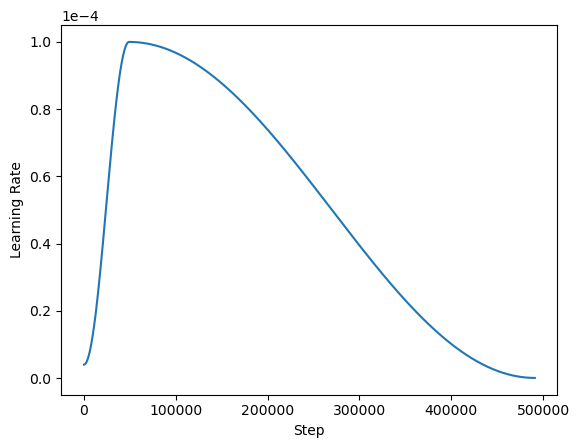

In [23]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = config.EPOCHS
BATCHES = len(train_dataloader)
steps = []
lrs = []
optim_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-4,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-4,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)

device = config.DEVICE
epochs = config.EPOCHS
model.to(device)
model.train()
losses = []

for epoch in range(epochs):
    print(f"====== EPOCH {epoch} ======")
    loss_meter = AverageMeter()
    with tqdm(train_dataloader, unit="train_batch") as tqdm_train_dataloader:
        for step, batch in enumerate(tqdm_train_dataloader):
            flattened_patches = batch.pop("flattened_patches").to(device)
            attention_mask = batch.pop("attention_mask").to(device)
            labels = batch.pop("labels").to(device)
            outputs = model(
                flattened_patches=flattened_patches,
                attention_mask=attention_mask,
                labels=labels
            )
            batch_size = flattened_patches.shape[0]
            loss = outputs.loss
            loss_meter.update(loss.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    losses.append(loss_meter.avg)
    print(f"Average Loss: {loss_meter.avg}")

# <b><span style='color:#F1A424'>|</span> Save Model</b><a class='anchor' id='save_model'></a> [↑](#top) 

***

In [ ]:
processor.save_pretrained("/kaggle/working")
model.save_pretrained("/kaggle/working")

# <b><span style='color:#F1A424'>|</span> Evaluate</b><a class='anchor' id='evaluate'></a> [↑](#top) 

***

In [30]:
model.eval()
with torch.no_grad():
    for step, batch in enumerate(tqdm(val_dataloader, unit="valid_batch")):
        flattened_patches = batch.pop("flattened_patches").to(device)
        attention_mask = batch.pop("attention_mask").to(device)
        prediction = model.generate(
            flattened_patches=flattened_patches,
            attention_mask=attention_mask,
            max_new_tokens=512,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id
        )
        if step%10==0:
            print(f'Step: {step} | Prediction: {processor.batch_decode(prediction, skip_special_tokens=True)}'), print("\n")
            print(f'Step: {step} | Ground Truth: {batch.pop("text")}'), print("\n")
            print("\n")

 12%|█▎        | 1/8 [00:01<00:09,  1.32s/valid_batch]

Step: 0 | Prediction: ['<s_chart> vertical_bar</s_chart><s_x_values> Opera;Others;Edge;IE;Safari;Firefox;Chrome</s_x_values><s_y_values> 150;80;70;65;90;85;92;98</s_y_values>', '<s_chart> vertical_bar</s_chart><s_x_values> Eastern Thailand;Eastern Cambodia;SE Viet Nam;SW Viet Nam</s_x_values><s_y_values> 31.3;34.3;18.6;51.6</s_y_values>']


Step: 0 | Ground Truth: ['<s_chart>vertical_bar</s_chart><s_x_values>Opera;Others;Edge;IE;Safari;Firefox;Chrome</s_x_values><s_y_values>102;154;169;246;404;404;2480</s_y_values>', '<s_chart>vertical_bar</s_chart><s_x_values>Eastern Thailand;Eastern Cambodia;SE viet Nam;SW Viet Nam</s_x_values><s_y_values>32.1;39.5;16.5;52.8</s_y_values>']






 25%|██▌       | 2/8 [00:02<00:08,  1.46s/valid_batch]

Step: 1 | Prediction: ['<s_chart> vertical_bar</s_chart><s_x_values> Germany;Switzerland;Hungary;Belgium;Indonesia;Niger;Vietnam;Saint Vincent and G.</s_x_values><s_y_values> 6.1;1.4;3.4;1.5;1.0;2.0;1.5;1.2;1.4;2.2</s_y_values>', '<s_chart> vertical_bar</s_chart><s_x_values> 11;12;13;14;15;16</s_x_values><s_y_values> 108.6;295.3;183.3;266.7;276.5;72.9</s_y_values>']


Step: 1 | Ground Truth: ['<s_chart>vertical_bar</s_chart><s_x_values>Afghanistan;Libya Sanctions;Sudan (Darfur);Humanitarian issues in Syria;Children and Armed Conflict;Humanitarian issues in Syria;West Africa and the Sahel;Afghanistan;Non-proliferation of WMD;Guinea-Bissau;West Africa and the Sahel;Criminal Tribunals;Working Methods</s_x_values><s_y_values>4;0;0;0;3;0;0;2;0;2;0;1;1</s_y_values>', '<s_chart>vertical_bar</s_chart><s_x_values>11;12;13;14;15;16</s_x_values><s_y_values>107;297;184;259;262;71</s_y_values>']






 38%|███▊      | 3/8 [00:04<00:07,  1.47s/valid_batch]

Step: 2 | Prediction: ['<s_chart> line</s_chart><s_x_values> 1900;1995;2006;2010</s_x_values><s_y_values> 36.6;14.3;39.3;46.8;53.7;46.8</s_y_values>', '<s_chart> vertical_bar</s_chart><s_x_values> 2014;2015;2016;2017</s_x_values><s_y_values> 6.6;2.2;100.2;76.5</s_y_values>']


Step: 2 | Ground Truth: ['<s_chart>line</s_chart><s_x_values>1990;2000;2010</s_x_values><s_y_values>45.3;42.8;39.2</s_y_values>', '<s_chart>vertical_bar</s_chart><s_x_values>2014;2015;2016;2017</s_x_values><s_y_values>5;25;100;75</s_y_values>']






 50%|█████     | 4/8 [00:07<00:07,  1.94s/valid_batch]

Step: 3 | Prediction: ['<s_chart> line</s_chart><s_x_values> 0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20</s_x_values><s_y_values> 0.5042;1.2;3.0;2.9;3.4;2.6;1.1;3.7;4.9;5.4;4.7;3.0;2.6;1.4;1.0</s_y_values>', '<s_chart> vertical_bar</s_chart><s_x_values> Player 1;Player 2;Player 3;Player 4;Player 5</s_x_values><s_y_values> 10;40;19;16;20</s_y_values>']


Step: 3 | Ground Truth: ['<s_chart>line</s_chart><s_x_values>0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20</s_x_values><s_y_values>0.0104;0.5221;1.0337;1.5453;1.9982;2.5;3.0;3.5;4.0;4.4;4.9;4.4;4.0;3.4;2.8;2.3;1.9921;1.4829;0.9587;0.4645;0.0152</s_y_values>', '<s_chart>vertical_bar</s_chart><s_x_values>Player 1;Player 2;Player 3;Player 4;Player 5</s_x_values><s_y_values>10;40;20;9;20</s_y_values>']






 62%|██████▎   | 5/8 [00:28<00:27,  9.05s/valid_batch]

Step: 4 | Prediction: ['<s_chart> vertical_bar</s_chart><s_x_values> Salt tolerant;Salt tolerant (hypyl-alban;Salt tolerant (alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoholic-alcoh

 75%|███████▌  | 6/8 [00:31<00:13,  6.83s/valid_batch]

Step: 5 | Prediction: ['<s_chart> line</s_chart><s_x_values> 40;80;120;160;200;240;280;320;360;400</s_x_values><s_y_values> 0.3161;1.2034;2.6;3.4;5.2;6.2;7.2;8.4</s_y_values>', '<s_chart> line</s_chart><s_x_values> 1800;1840;1860;1880;1900;1920;1940;1960;1980;2000</s_x_values><s_y_values> 1047;1055;1080;1065;1097;1104;1205;1374;597;5720;5475;5910;9472</s_y_values>']


Step: 5 | Ground Truth: ['<s_chart>line</s_chart><s_x_values>40;80;120;160;200;240;280;320;360;400</s_x_values><s_y_values>0.4703;1.2713;2.1;3.1;4.0;4.8;5.7;6.6;7.4;8.3</s_y_values>', '<s_chart>line</s_chart><s_x_values>1820;1840;1860;1880;1900;1920;1940;1960;1980;2000</s_x_values><s_y_values>5953;10361;14663;19558;25899;21934;55271;50550;90911;86780</s_y_values>']






 88%|████████▊ | 7/8 [00:32<00:04,  4.94s/valid_batch]

Step: 6 | Prediction: ['<s_chart> line</s_chart><s_x_values> 1;2;3;4;5;6;7;10</s_x_values><s_y_values> 9.5;23.3;25.2;47.2;59.7;75.4</s_y_values>', '<s_chart> line</s_chart><s_x_values> 10;20;30;40;50;60</s_x_values><s_y_values> 1;2;4;8;1;5;4;9</s_y_values>']


Step: 6 | Ground Truth: ['<s_chart>line</s_chart><s_x_values>1;2;3;4;5;6;7;8;9;10</s_x_values><s_y_values>10;20;30;25;21;40;50;35;16;71</s_y_values>', '<s_chart>line</s_chart><s_x_values>10;20;30;40</s_x_values><s_y_values>4;8;8;8</s_y_values>']






100%|██████████| 8/8 [00:36<00:00,  4.52s/valid_batch]

Step: 7 | Prediction: ['<s_chart> line</s_chart><s_x_values> 1925;1930;1935;1940;1945;1960;1965;1970;1975;1978;1980;1985;1996;2000;2004;2010</s_x_values><s_y_values> 1325;1080;1935;1940;1947;1950;1965;1960;1970;1975;1980;1985;1996;2000;2006</s_y_values>', '<s_chart> horizontal_bar</s_chart><s_x_values> 0.015;10.0;20.0;30.0;40.0;50.0;60.0;70.0;80.0;90.0;100.0;15.0</s_y_values>']


Step: 7 | Ground Truth: ['<s_chart>line</s_chart><s_x_values>1925;1930;1935;1940;1947;1950;1955;1960;1965;1970;1975;1980;1985;1990;1995;2000;2005;2010</s_x_values><s_y_values>135834;135834;148182;147342;108735;189344;189344;189344;268822;555611;1467474;2691805;4264349;6120660;7890864;10809896;14719415;17022788</s_y_values>', '<s_chart>horizontal_bar</s_chart><s_x_values>38.6;1.1029;30.5;10.2;1.3235;4.7;1.3235;3.2;10.2</s_x_values><s_y_values>Opportunity to save and receive loans;Protection against harassment from offenders or others;Better information about alternative job offers;Access to health and pension;M